## Making the BPT calculation work for Python

In [386]:
# Loading some stuff... 
from __future__ import print_function
import numpy as np
from scipy import stats, io
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import h5py
import base64
from IPython.display import Image


So Matthew generously sent some code to calculate the BPT in ECCO-GODAE version 3. This is calculated as:

$$ w_{b} = u_{b}\cdot \nabla (H) = \frac{1}{\rho_{0}f}J(p, H)|_{b}. $$

I like to think of it in terms of vortex retching and squishing... This isn't strictly correct, but it's a nice place to start assuming no normal flow at the bottom:


\begin{equation}
\begin{split}
\dfrac{1}{\rho_{0}} J(p_{b}, H) &= \dfrac{1}{\rho_{b}} \left[ \dfrac{\partial p_{b}}{\partial x} \dfrac{\partial H}{\partial y} - \dfrac{\partial p_{b}}{\partial y} \dfrac{\partial H}{\partial x} \right]\\
 & = f \left[ v_{gb} \dfrac{\partial H}{\partial y} + u_{gb} \dfrac{\partial H}{\partial x} \right]\\
 & = f \textbf{v}_{gb} \cdot \nabla H\\
 & =-f w_{gb}
\end{split}
\end{equation}

If you want to be more finicky:
$$ \begin{aligned}
 \left( \frac{D \mathbf u_b}{D t}  - \frac{\partial \tau}{\partial z} \right) \cdot |\nabla H| \mathbf t_H + f \mathbf u \cdot \nabla H = - k \cdot \nabla H \times & \nabla p_b \\
 & \| \\
J &\left(p_b, H \right).
 \end{aligned} $$
 
We arrive at this from the depth intragrated transport. See Highes and de Cuevas 2001 for a full derivation... (Or Matthew's paper, or my draft...)

I basically just go through what Matthew did step by step. Add some figures and verify at the end.

In [1]:
#Bundle some plotting stuff..
def makeFig(data, cMin, cMax, cStep, title, ColMap, saveName):
        dataIn = data
        lons = np.roll(np.linspace(0, 360, 360),100)
        lons = lon_cMatt
        dataIn,lons = shiftgrid(lon_cMatt[0],np.flipud(dataIn),lons,start=True, cyclic=360)
        lats = lat_cMatt
        llons, llats = np.meshgrid(lons,lats)
        fig = plt.figure()
        ax = fig.add_axes([0.05,0.05,0.9,0.9])
        # create Basemap instance.
        m = Basemap(projection='kav7',lon_0=130,resolution='l')
        m.drawmapboundary(fill_color='0.9')
        im1 = m.contourf(llons,llats,np.fliplr(np.fliplr(dataPlot)),np.arange(cMin, cMax, cStep),shading='flat',cmap=ColMap,latlon=True)
        m.drawmapboundary(fill_color='0.9')
        m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
        m.drawmeridians(np.arange(-180.,180.,60.),labels=[1,1,0,1])
        m.drawcoastlines()
        m.fillcontinents()
        cb = m.colorbar(im1,"bottom", size="5%", pad="9%")
        # add a title.
        ax.set_title(title)
        plt.savefig(saveName, format='png', dpi=500)
        plt.show()

So I used the data Matthew gave us. Below I just load the data, and plot for a ballpark sanity check.

In [99]:
b_prMattF=io.loadmat('/home/maike/Documents/BPT/BPT_calc/time_mean_pressbot.mat')
b_pr=b_prMattF['botpress_mean']
lat_c=b_prMattF['lat_c']
lon_c=b_prMattF['lon_c']

In [160]:
ecco_paramsF=io.loadmat('/home/maike/Documents/BPT/BPT_calc/ecco_params.mat')
time_mean_pressF=io.loadmat('/home/maike/Documents/BPT/BPT_calc/time_mean_press.mat')
depth_l=ecco_paramsF['depth_l']
lat_v=ecco_paramsF['lat_v']
hydpress_mean=time_mean_pressF['hydpress_mean']

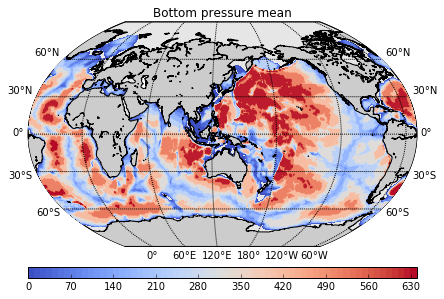

In [376]:
makeFig(b_prMatt, 0,650,10, 'Bottom pressure mean', plt.cm.coolwarm,'bprMatt.png')

Right, so  now I'll just translate this step by step from what Matthew sent. I'm double checking using Octave (read: Matlab)

### Establish some standard values

In [42]:
lon_diff=1.111774765625000e+05
Omega=7.2921e-5 #2*np.pi/T

f=np.array(2*Omega*np.sin((np.arange(np.min(lat_c),np.max(lat_c)+abs(lat_c[2]-lat_c[1]),abs(lat_c[2]-lat_c[1])))*np.pi/180)) # coriolis parameter at cell centre

beta_fgrid=np.zeros(lat_c.shape[0]);beta_fgrid[:]=np.nan  
beta_fgrid[1:160]=((f[1:160]-f[0:159])/(lon_diff)) # Gives beta at the cell corner (the vorticity point)
beta_fgrid=beta_fgrid.repeat(360).reshape(160,360)   # Just makes it 2D

In [295]:
# grid cell widths and heights etc. 
grid_width_u=(lon_diff*np.cos(lat_c*np.pi/180))*np.ones(360)
grid_width_v=(lon_diff*np.cos(lat_v*(np.pi/180)))*np.ones(360)
depth_l_diff=np.append(10,np.diff(np.abs(depth_l[:,0])))
depth_l_diff_glob=np.repeat(depth_l_diff,(160*360)).reshape(23,160,360)
grid_width_u_glob=np.tile(grid_width_u,(23,1,1))#.reshape(23,160,360)
grid_width_v_glob=np.tile(grid_width_v,(23,1,1))#.reshape(23,160,360)

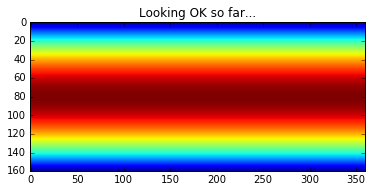

In [377]:
plt.imshow(grid_width_v_glob[0,...])
plt.title('Looking OK so far...')

### Determine the pressure gradient term in the depth-integrated momentum equation. 

In [298]:
# calculate gradients. 
gradp_i=np.zeros(grid_width_v_glob.shape);gradp_i[:]=np.nan
gradp_j=np.zeros(grid_width_v_glob.shape);gradp_j[:]=np.nan

gradp_i[:,:,1:]=-(hydpress_mean[:,:,1:]-hydpress_mean[:,:,0:-1])
gradp_i[:,:,0]=(-(hydpress_mean[:,:,0]-hydpress_mean[:,:,-1]))
gradp_i=gradp_i/grid_width_u_glob
gradp_j[:,1:,:]=(-(hydpress_mean[:,1:,:]-hydpress_mean[:,0:-1,:]))
gradp_j=gradp_j/lon_diff

In [299]:
# vertically integrate grad(p) to bottom. 
gradp_int_i=np.nansum(gradp_i[:,:,:]*depth_l_diff_glob[:,:,:],0)
gradp_int_j=np.nansum(gradp_j[:,:,:]*depth_l_diff_glob[:,:,:],0)

### Calculate the form stress term in the depth-integrated momentum equation.

In [300]:
# vertically integrate p to bottom. 
p_int=np.nansum(hydpress_mean[:,:,:]*depth_l_diff_glob[:,:,:],0)

In [301]:
# take gradient
grad_intp_i=np.zeros(p_int.shape);grad_intp_i[:]=np.nan
grad_intp_j=np.zeros(p_int.shape);grad_intp_j[:]=np.nan

grad_intp_i[:,1:]=-(p_int[:,1:]-p_int[:,0:-1])
grad_intp_j[1:,:]=-(p_int[1:,:]-p_int[0:-1,:])
grad_intp_i[:,0]=-(p_int[:,0]-p_int[:,-1])
grad_intp_i=grad_intp_i/grid_width_u
grad_intp_j=grad_intp_j/lon_diff

In [302]:
# The form stress term:
pb_gradH_i=gradp_int_i-grad_intp_i
pb_gradH_j=gradp_int_j-grad_intp_j

### Compute curl (in spherical polar coordinates) to get the depth-integrated vorticity equation. 

In [303]:
np.rollaxis(np.tile(depth_l_diff,(160,360,23)),2,0)

coslatc_glob=np.tile(np.cos(lat_c*np.pi/180)*np.ones(360),(23,1,1)) # cosine of latitude (on the c-point) everywhere on the globe
coslatv_glob=np.tile(np.cos(lat_v*np.pi/180)*np.ones(360),(23,1,1)) # cosine of latitude (on the v-point) everywhere on the globe

# first scale the zonal terms with cos(lat). Needed for the spherical coordinate calculation. 
# Spherical coordinate calculations are based on this page: https://en.wikipedia.org/wiki/Del_in_cylindrical_and_spherical_coordinates
gradp_i_scale=gradp_i*coslatc_glob
gradp_int_i_scale=gradp_int_i*coslatc_glob[0,:,:]
grad_intp_i_scale=grad_intp_i*coslatc_glob[0,:,:] #OK
pb_gradH_i_scale=pb_gradH_i*coslatc_glob[0,:,:]

In [304]:
# Find the curl of the depth integrated pressure gradient. This is the term used for BPT. 
NansToPad=np.zeros((1,360)); NansToPad[:]=np.nan
curl_gradp_int_kcomp=(np.insert(gradp_int_i_scale[1:,:]-gradp_int_i_scale[0:-1,:], 0, NansToPad, axis = 0)/(coslatv_glob[0,:,:]*lon_diff))-(np.insert((gradp_int_j[:,1:]-gradp_int_j[:,0:-1]), 0, NansToPad[0,0:160], axis = 1)/grid_width_v)
#and calculate the first longitude index
#curl_gradp_int_kcomp(:,1)=(padarray((gradp_int_i_scale(2:end,1)-gradp_int_i_scale(1:end-1,1)),[1 0],nan,'pre')./(coslatv_glob(1,:,1)'.*lon_diff))...
#    -((gradp_int_j(:,1)-gradp_int_j(:,end))./grid_width_v(:,1));


In [324]:
#This is it!
BPT=curl_gradp_int_kcomp/beta_fgrid

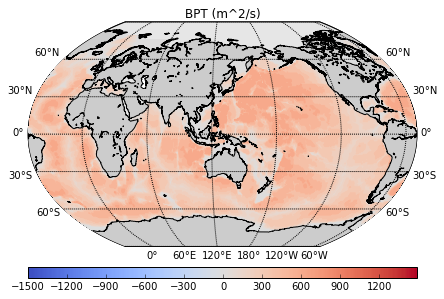

In [357]:
makeFig(BPT, -1500,1500,10, 'BPT (m^2/s)', plt.cm.coolwarm,'BPT_Matt.png')
#Tada!!

Right, now we load the data from using Matt's matlab code to compare...

In [336]:
BPT_MattF=h5py.File('/home/maike/Documents/BPT/BPT_calc/bpt.h5', 'r')
bpt_matt = BPT_MattF['BPT']
bpt_matt = bpt_matt['value']

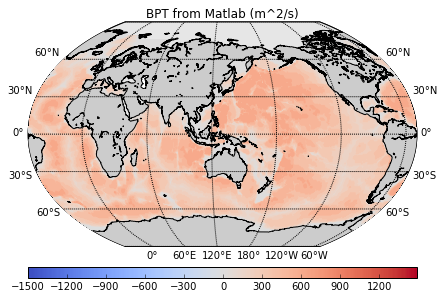

In [356]:
makeFig(bpt_matt, -1500,1500,10, 'BPT from Matlab (m^2/s)', plt.cm.coolwarm,'BPT_Matt_matlab.png')

Just to demonstrate, it's machine precision, so I'm OK saying the above python code does what the matlab code Matt developed does!

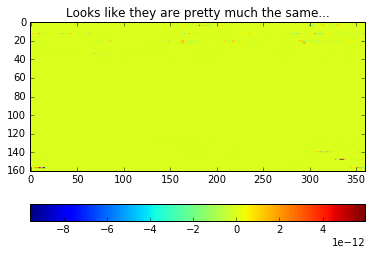

In [375]:
plt.imshow(BPT+np.flipud(np.rot90(bpt_matt[:],1)))
plt.colorbar(orientation='horizontal')
plt.title('Looks like they are pretty much the same...' )

### Right; fabulous! Just some thought's to round off:

1: Next step is to make this work for ECCOv4! Then onwards in the vorticity budget!

2: Would be cool just to check if the whole:
$$ w_{b} = u_{b}\cdot \nabla (H) = \frac{1}{\rho_{0}f}J(p, H)|_{b}. $$
I'm curious mainly as ECCO doesn't do the partial cells. Wells and de Cuevas 1995 had some interesting figures showing that you had to ignore the points where the change in bathymetry were too abrupt. This would likely be exagerated in ECCO as it's quite coarse. 

3: Overall, I guess my main interest is playing with this is how ECCO measures up against other models. I really like the thought of recreating something like the figure below from Schonoover (2016), but adding info from the sensitivities. The below is just for the North Atlantic gyre, so I'd have to think of a good way to graphically present it, but I think you could start comenting on how the sensitivities express themselves on the vorticity budget. That's my goal anyhows!

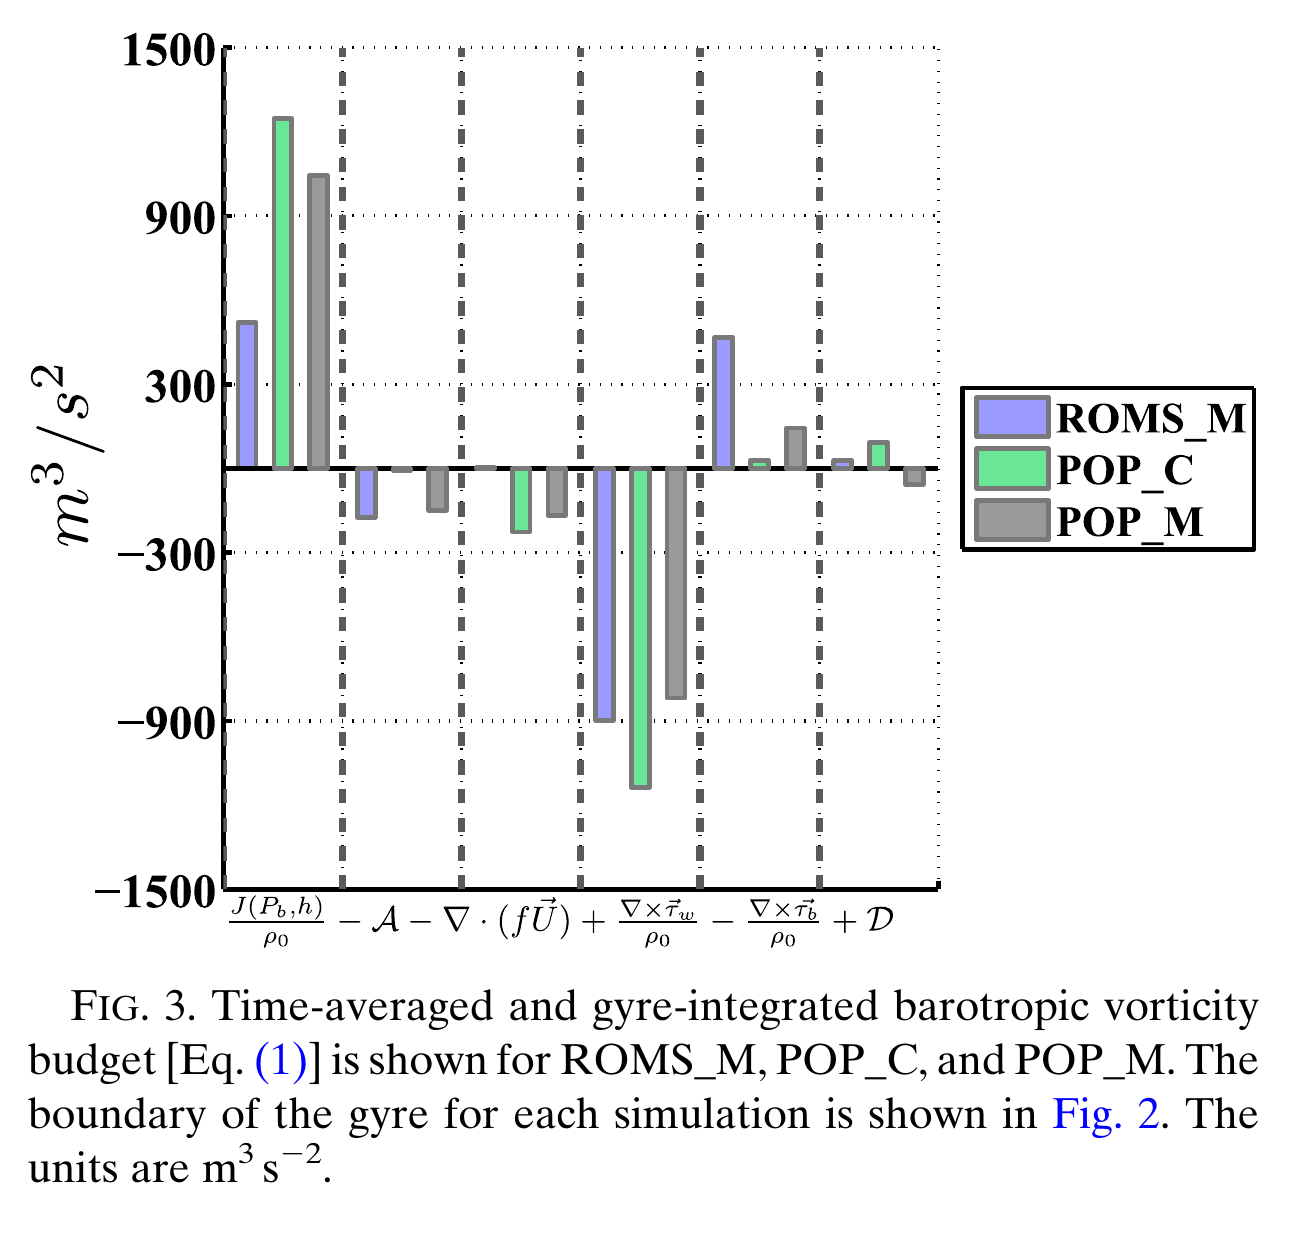

In [382]:
Image(filename="/home/maike/Documents/BPT/schoonover2016Fig3.png")

### Finally: General thoughts on looking at the impact on the gyre circulation and the overturning streamfunction

To assess the impact of the BPT and other terms, it would be useful to know their impact on the overturning. Here, is a bit on the theoretical foundation of this link. It's a bit pie-in-the-sky, but worth hashing out!

If we use the barotropic vorticity relation, and keep the (horizontal) non-divergence in mind implied by:

\begin{equation}
 \nabla \cdot \textbf{U} = \nabla \cdot \textbf{U}_{g} + \nabla \cdot \textbf{U}_{ag} = - \partial_{t} h
\end{equation}

Where "g" is the geostrophic component and "ag" is the ageostrophic component. We can recast the equation as a streamfunction equation for the barotropic gyre circulation:
\begin{equation}
\begin{split}
 \beta \partial_{x} \psi_{G} &=  \dfrac{1}{\rho_{0}} J(p_{b}, H) +  \dfrac{1}{\rho_{0}} \nabla \times \Delta \tau\\
 \psi_{G} &= -\dfrac{1}{\beta} \int^{x_{e}}_{x_{w}}\left[\dfrac{1}{\rho_{0}} J(p_{b}, H) +  \dfrac{1}{\rho_{0}} \nabla \times \Delta \tau \right] dx \\
 \psi_{G} &=\psi_{G}^{BPT} + \psi_{G}^{\tau}
\end{split}
\end{equation}

Where $\textbf{U} = \mathbf{k} \times \nabla \psi_{G}$ the "G" is for gyre. Here we follow Yeager (2015), looking at the gyre circulation in the North Atlantic first (We leave out the non-linear and lateral friction terms, which can easily be added). A closure at the western boundary is implied ($\psi_{G}(x_{w}) = 0$) with the integral balance of terms:

\begin{equation}
0 = \int^{x_{e}}_{x_{w}}\left[\dfrac{1}{\rho_{0}} J(p_{b}, H) +  \dfrac{1}{\rho_{0}} \nabla \times \Delta \tau \right] dx
\end{equation}

In depth-space, where the overturning ("o") streamfunction is defined in the y-z plane ($-\partial_{z} \psi_{o} = \int^{x_{e}}_{x_{w}} v dx$ and $\partial_{y} \psi_{o} = \int^{x_{e}}_{x_{w}} w dx$) this translates to:

\begin{equation}
\begin{split}
 \psi_{o} &= -\dfrac{1}{\beta} \int^{x_{e}}_{x_{w}}\left[\dfrac{1}{\rho_{0}} J(p_{b}, H)(z) +  \dfrac{1}{\rho_{0}} \nabla \times \Delta \tau (z) \right] dx \\
 \psi_{o} &=\psi_{o}^{BPT} + \psi_{o}^{\tau}
\end{split}
\end{equation}

Or in density-space:

\begin{equation}
\begin{split}
 \psi_{\rho} &= -\dfrac{1}{\beta} \int^{x_{e}}_{x_{w}}\left[\dfrac{1}{\rho_{0}} J(p_{b}, H)(\rho) +  \dfrac{1}{\rho_{0}} \nabla \times \Delta \tau (\rho) \right] dx \\
 \psi_{\rho} &=\psi_{\rho}^{BPT} + \psi_{\rho}^{\tau}
\end{split}
\end{equation}


Here the partial z (or $\rho$) implies the closure $\psi_{0}(\nu) = 0$ (and a statically stable water column for $\rho$), and highlights the importance of abyssal flows and the bathymetric control on the deep meridional flow closing the overturning circulation.

In this manner we could assess the relative contributions to the vorticity balance in density space. This would be particularily interesting in terms of the long term mean and the more transient monthly means, where the importance of terms such as the BPR etc terms will likely reveal changes in the mecanisms active to realise the overturning and gyre circulation... 

Comments?


### PDF aside:

I thought it would be nice just to have a quick look at how the probability distribution functions look. In sum, they look \textbf{really} smooth. I think this is probably because we're working directly on the time mean data. I added a plot from NEMO to illustrate what sort of shape I was expecting..

Comments?

In [399]:
def makeMaskSection(data,upper,lower,section):
    nx,ny=data.shape
    mask = np.fromfunction(lambda i, j: ((data[section,:]<upper) & (data[section,:]>=lower)), (nx, ny), dtype=int)
    return mas

def makeMask(data,upper,lower):
    nx,ny=data.shape
    mask = np.fromfunction(lambda i, j: ((data[:,:]<=upper) & (data[:,:]>lower)), (nx, ny), dtype=int)
    return mask

def maskArray(Array,mask):
    maskedArray = ma.masked_array(Array, mask[:])
    return maskedArray

def pdfCalc(data,area,maskf,steps):
    bins=np.linspace(-2000, 2000, steps)#np.min(data), np.max(data), steps)
    pdf=np.empty(bins.shape)
    #counter = 1
    for nr in xrange(len(bins)-1):
        #print nr, nr+1,bins[nr+1], bins[nr]
        upper = bins[nr+1]
        lower = bins[nr]
        maskNr = makeMask(data,upper,lower)
        mA = maskArray(area, ~maskNr)
        pdf[nr] = np.nansum(mA*maskf)#[0,0,...])
        if nr%1==10: print(upper,lower)
        #counter=counter+1
        #print nr
    return pdf, bins

def pdfCalcLat(data,area,maskf,steps):
    nx,ny=data.shape
    bins=np.linspace(-2000, 2000, steps)
    pdf=np.empty([nx,steps])
    counter = 1
    for nr in xrange(len(bins)-1):
        #print nr
        upper = bins[nr+1]
        lower = bins[nr]
        maskNr = makeMask(data,upper,lower)
        mA = maskArray(area, ~maskNr)
        pdf[:,nr] = np.nansum(mA*maskf[...],axis=1)
        if nr%1==10: print(upper,lower)
        counter=counter+1
    return pdf, bins

In [390]:
area = grid_width_v_glob[0,...]*grid_width_u_glob[0,...]

In [417]:
mask=np.ones(BPT.shape)
index = np.isnan(b_prMatt)
mask[index]=np.nan

pdfBPT, bins = pdfCalc(BPT,area,mask,100)
pdfBPTLat, bins = pdfCalcLat(BPT,area,mask,100)

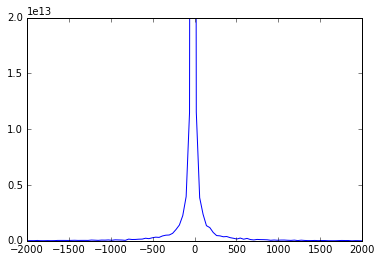

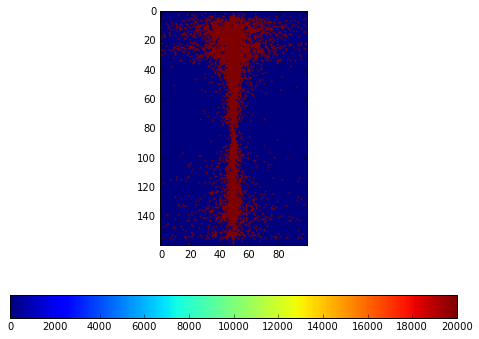

In [428]:
plt.plot(bins,pdfBPT)
plt.ylim(0,0.2e14)
plt.figure(figsize=(8, 6))
plt.imshow(pdfBPTLat)
plt.clim(0,20000)
plt.colorbar(orientation='horizontal')

For comparison from NEMO. Things that stand out is how smoth ECCO is. I was expecting something like ORCA1 (1$^{\circ}$)? Also, ECCO seems to cluster around the northern Hemisphere, rather than more uniformly/around the Southern Ocean? Can we think of a reason for this? Again I wonder about working on the time mean data...

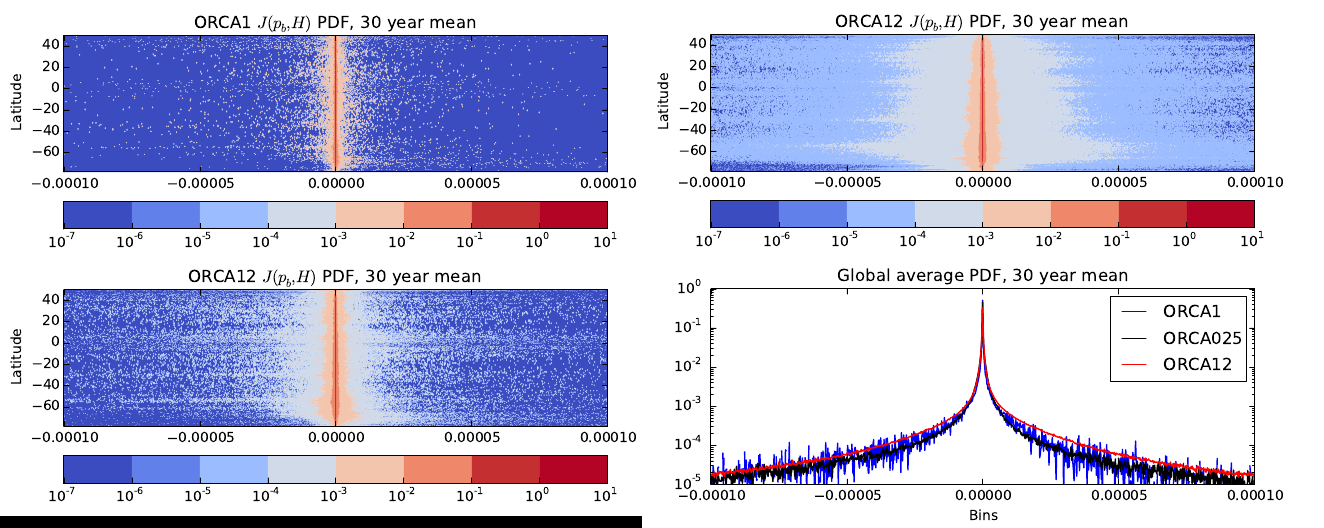

In [427]:
Image(filename="/home/maike/Documents/BPT_draft/talkPDFmeanBPT.png")